In [1]:
from __future__ import annotations

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from ipywidgets import HBox, IntSlider, VBox, interactive_output

from curvelets.numpy.udct import UDCT

In [2]:
shape = (256, 128)
zeros_img = np.zeros(shape)
cfg = np.array([[3, 3], [3, 3]])
C = UDCT(size=shape, cfg=cfg)
coeffs_zero = C.forward(zeros_img)

In [3]:
def display_curvelet(scale=1, direction=1, wedge=1, i0=1, i1=1):
    s = scale - 1
    d = direction - 1
    w = wedge - 1

    # Populate curvelet
    y_new = deepcopy(coeffs_zero)
    A, B = y_new[s][d][w].shape
    i0 = max(1, min(i0, A))
    i1 = max(1, min(i1, B))
    y_new[s][d][w][i0 - 1, i1 - 1] = 1.0

    x = C.backward(y_new)
    n0, n1 = x.shape

    x_fk = np.fft.fft2(x)
    x_fk = np.fft.fftshift(x_fk)

    vmin, vmax = 0.5 * np.array([-1, 1]) * np.abs(np.max(x))
    extent = [-0.5, n0 + 0.5, n1 + 0.5, -0.5]
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex="row", sharey="row")
    ax[0, 0].imshow(np.real(x.T), cmap="gray", vmin=vmin, vmax=vmax, extent=extent)
    ax[0, 1].imshow(np.imag(x.T), cmap="gray", vmin=vmin, vmax=vmax, extent=extent)
    ax[1, 0].imshow(np.abs(x_fk.T), cmap="turbo", vmin=0, extent=extent)
    mask = np.abs(x_fk) > 0.01 * np.abs(x_fk).max()
    ax[1, 1].imshow(
        (mask * np.angle(x_fk, deg=True)).T,
        cmap="twilight_shifted",
        vmin=-180,
        vmax=180,
        extent=extent,
    )
    ax[0, 0].set(title="Space domain (Real)")
    ax[0, 1].set(title="Space domain (Imag)")
    ax[1, 0].set(title="Frequency domain (Abs)")
    ax[1, 1].set(title="Frequency domain (Phase)")
    ax[0, 0].axvline(n0 * (i0 - 1) / A, color="y", alpha=0.5)
    ax[0, 0].axhline(n1 * (i1 - 1) / B, color="y", alpha=0.5)
    ax[0, 1].axvline(n0 * (i0 - 1) / A, color="y", alpha=0.5)
    ax[0, 1].axhline(n1 * (i1 - 1) / B, color="y", alpha=0.5)
    fig.tight_layout()

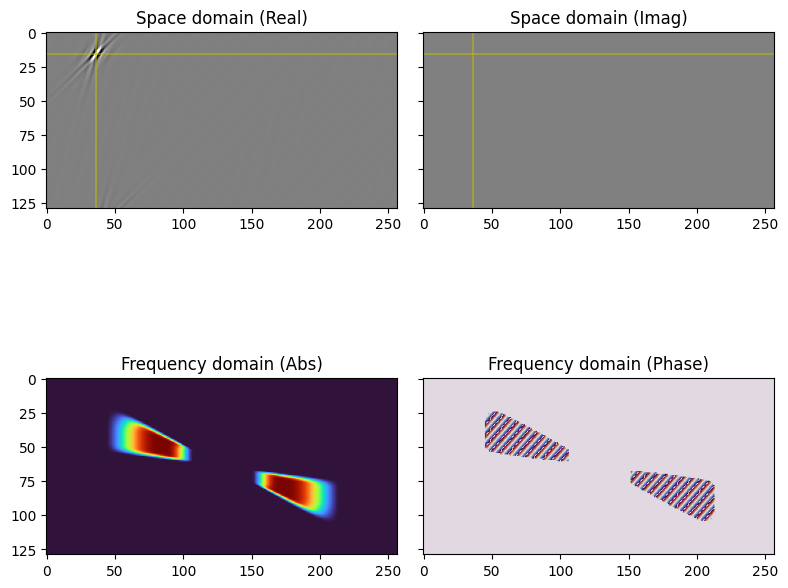

In [4]:
display_curvelet(scale=2, direction=1, wedge=1, i0=10, i1=5)

In [5]:
curr_scale = 1
curr_direction = 1
curr_wedge = 1
max_i0, max_i1 = coeffs_zero[curr_scale - 1][curr_direction - 1][curr_wedge - 1].shape

max_scale = 1 + max(coeffs_zero.keys())
max_direction = len(coeffs_zero[curr_scale - 1])
max_wedge = len(coeffs_zero[curr_scale - 1][curr_direction - 1])

slider_scale = IntSlider(
    min=1,
    max=max_scale,
    value=curr_scale,
    step=1,
    description=f"Scales [1-{max_scale}]",
    style={"description_width": "100px"},
)
slider_direction = IntSlider(
    min=1,
    max=max_direction,
    value=curr_direction,
    step=1,
    description=f"Direction [1-{max_direction}]",
    style={"description_width": "100px"},
)
slider_wedge = IntSlider(
    min=1,
    max=max_wedge,
    value=curr_wedge,
    step=1,
    description=f"Wedge [1-{max_wedge}]",
    style={"description_width": "100px"},
)
slider_i0 = IntSlider(
    min=1,
    max=max_i0,
    value=max_i0 // 2,
    step=1,
    description=f"X [1-{max_i0}]",
    style={"description_width": "100px"},
)
slider_i1 = IntSlider(
    min=1,
    max=max_i1,
    value=max_i1 // 2,
    step=1,
    description=f"Y [1-{max_i1}]",
    style={"description_width": "100px"},
)


def handle_scale_change(change):
    global curr_scale
    global curr_direction
    global curr_wedge
    curr_scale = change.new

    slider_direction.max = len(coeffs_zero[curr_scale - 1])
    curr_direction = slider_direction.value
    slider_direction.description = f"Direction [1-{slider_direction.max}]"

    slider_wedge.max = len(coeffs_zero[curr_scale - 1][curr_direction - 1])
    curr_wedge = slider_wedge.value
    slider_wedge.description = f"Wedge [1-{slider_wedge.max}]"

    A, B = coeffs_zero[curr_scale - 1][curr_direction - 1][curr_wedge - 1].shape
    oldi0, oldi1 = slider_i0.value, slider_i1.value
    oldA, oldB = slider_i0.max, slider_i1.max
    slider_i0.max = A
    slider_i1.max = B
    slider_i0.value = round((oldi0 - 1) * A / oldA) + 1
    slider_i1.value = round((oldi1 - 1) * B / oldB) + 1
    slider_i0.description = f"X [1-{slider_i0.max}]"
    slider_i1.description = f"Y [1-{slider_i1.max}]"


def handle_direction_change(change):
    global curr_scale
    global curr_direction
    global curr_wedge

    curr_direction = change.new

    slider_wedge.max = len(coeffs_zero[curr_scale - 1][curr_direction - 1])
    curr_wedge = slider_wedge.value
    slider_wedge.description = f"Wedge [1-{slider_wedge.max}]"

    A, B = coeffs_zero[curr_scale - 1][curr_direction - 1][curr_wedge - 1].shape
    slider_i0.max = A
    slider_i1.max = B
    oldi0, oldi1 = slider_i0.value, slider_i1.value
    oldA, oldB = slider_i0.max, slider_i1.max
    slider_i0.max = A
    slider_i1.max = B
    slider_i0.value = round((oldi0 - 1) * A / oldA) + 1
    slider_i1.value = round((oldi1 - 1) * B / oldB) + 1
    slider_i0.description = f"X [1-{slider_i0.max}]"
    slider_i1.description = f"Y [1-{slider_i1.max}]"


def handle_wedge_change(change):
    global curr_scale
    global curr_direction
    global curr_wedge
    curr_wedge = change.new
    A, B = coeffs_zero[curr_scale - 1][curr_direction - 1][curr_wedge - 1].shape
    oldi0, oldi1 = slider_i0.value, slider_i1.value
    oldA, oldB = slider_i0.max, slider_i1.max
    slider_i0.max = A
    slider_i1.max = B
    slider_i0.value = round((oldi0 - 1) * A / oldA) + 1
    slider_i1.value = round((oldi1 - 1) * B / oldB) + 1
    slider_i0.description = f"X [1-{slider_i0.max}]"
    slider_i1.description = f"Y [1-{slider_i1.max}]"


slider_scale.observe(handle_scale_change, names="value")
slider_direction.observe(handle_direction_change, names="value")
slider_wedge.observe(handle_wedge_change, names="value")

out = interactive_output(
    display_curvelet,
    {
        "scale": slider_scale,
        "direction": slider_direction,
        "wedge": slider_wedge,
        "i0": slider_i0,
        "i1": slider_i1,
    },
)
vbox1 = VBox([slider_scale, slider_direction, slider_wedge])
vbox2 = VBox([slider_i0, slider_i1])
ui = HBox([vbox1, vbox2])
display(ui, out)

Output()